# BloodMNIST Classification Pipeline

This notebook orchestrates the complete pipeline for blood cell type classification using the BloodMNIST dataset.

## Pipeline Overview:
1. **Import Libraries & Modules** - Load required dependencies
2. **Configuration** - Set hyperparameters and options
3. **Data Preparation** - Load and transform the dataset
4. **Data Exploration** - Visualize and understand the data
5. **Model Training** - Train classification models (TODO)
6. **Evaluation** - Assess model performance (TODO)

## 1. Import Libraries & Modules

In [361]:
import torch
import torch.nn as nn
import medmnist

# import custom modules from the backend directory
from backend.data_loading import (
    get_data_transforms,
    load_blood_mnist_datasets,
    print_dataset_info,
    create_dataloaders,
    show_image_batch
)
from backend.models.MLP import build_baseline_mlp
from backend.models.CNN import build_baseline_cnn
from backend.model_management import (
    record_experiment,
    list_result_runs,
    load_experiment
)
from backend.training import (
    train_model,
    predict_labels,
    compute_confusion_matrix
)

## 2. Configuration

Set the hyperparameters and configuration options for the pipeline.

In [362]:
# configuration parameters
BATCH_SIZE = 128 
DOWNLOAD = True   # download the dataset if not found locally

print(f"Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Download Dataset: {DOWNLOAD}")

Configuration:
  Batch Size: 128
  Download Dataset: True


## 3. Data Preparation

### 3.1 Get Data Transformations

Define the preprocessing transformations to be applied to images.

In [363]:
print("=== Step 1: Preparing data transformations ===")
data_transform = get_data_transforms()
print("Data transformations prepared")

=== Step 1: Preparing data transformations ===
Data transformations prepared


### 3.2 Load BloodMNIST Datasets

Download and load the train, validation, and test splits.

In [364]:
print("=== Step 2: Loading BloodMNIST datasets ===")
train_dataset, val_dataset, test_dataset = load_blood_mnist_datasets(
    data_transform=data_transform,
    download=DOWNLOAD
)
print("Datasets loaded successfully")

=== Step 2: Loading BloodMNIST datasets ===
Datasets loaded successfully


### 3.3 Dataset Information

Display detailed information about the dataset splits and classes.

In [365]:
print_dataset_info(train_dataset, val_dataset, test_dataset)


Dataset Information:
Number of training samples: 11959
Number of validation samples: 1712
Number of test samples: 3421
Task: multi-class
Number of channels: 3
Number of classes: 8
Class labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}


### 3.4 Create DataLoaders

Create PyTorch DataLoaders for efficient batch processing.

In [366]:
print("=== Step 3: Creating DataLoaders ===")
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    batch_size=BATCH_SIZE
)
print("DataLoaders created successfully")

=== Step 3: Creating DataLoaders ===

Created DataLoaders with batch size 128.
DataLoaders created successfully


## 4. Data Exploration

### 4.1 Visualize Training Data

Display a batch of training images to understand the data we're working with.

=== Step 4: Visualizing training data ===

Labels for the first row of images:
immature granulocytes(myelocytes, metamyelocytes and promyelocytes), immature granulocytes(myelocytes, metamyelocytes and promyelocytes), immature granulocytes(myelocytes, metamyelocytes and promyelocytes), immature granulocytes(myelocytes, metamyelocytes and promyelocytes), monocyte, neutrophil, eosinophil, erythroblast, eosinophil, immature granulocytes(myelocytes, metamyelocytes and promyelocytes), monocyte, neutrophil, erythroblast, erythroblast, monocyte, neutrophil


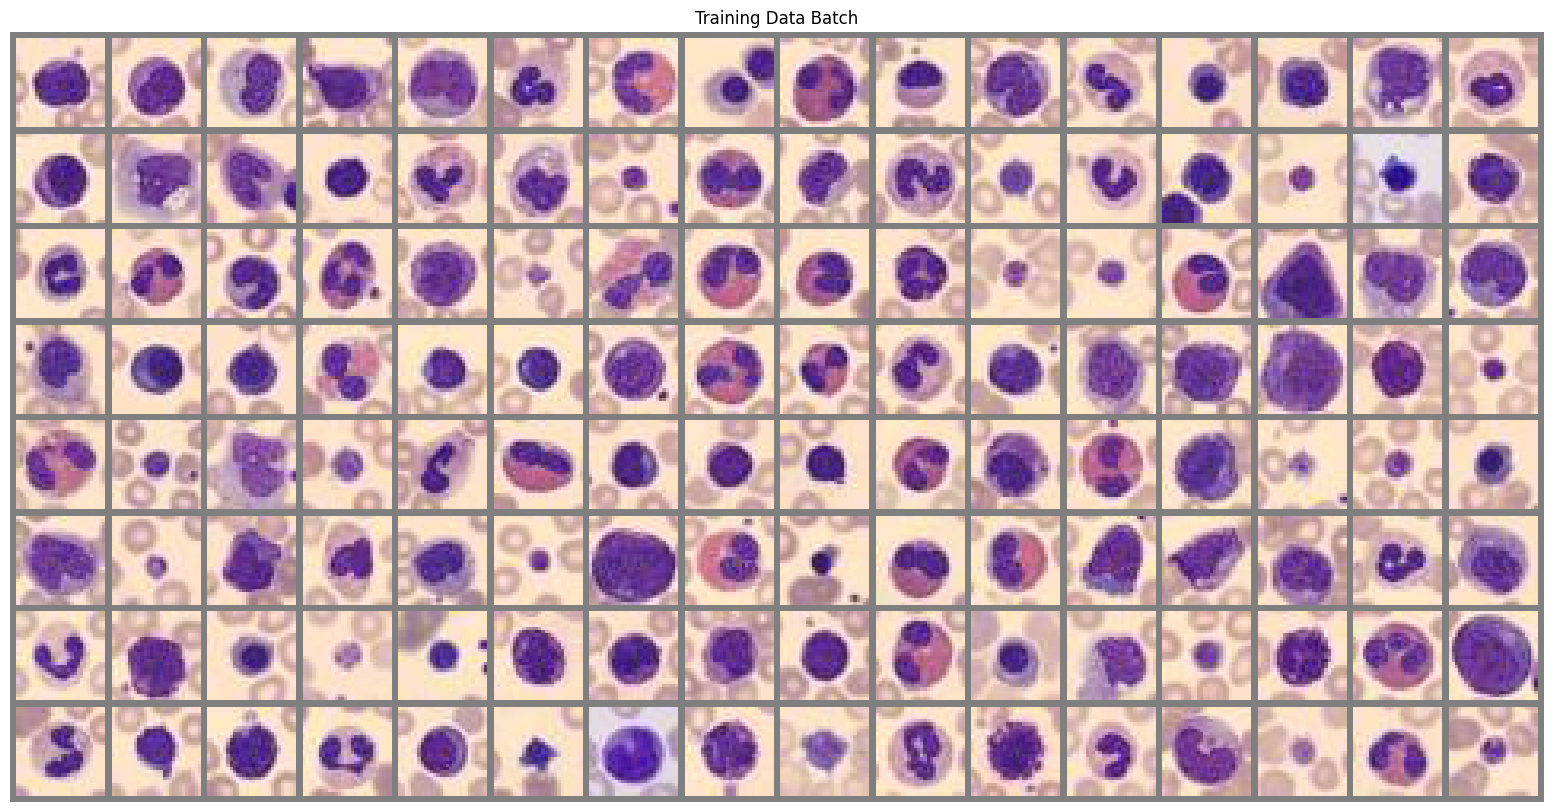

In [367]:
print("=== Step 4: Visualizing training data ===")
show_image_batch(
    data_loader=train_loader,
    dataset=train_dataset,
    title="Training Data Batch"
)

## 5. Baseline MLP Setup

Instantiate the baseline classifier and keep the loss and optimizer easy to tweak.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_architecture = {
    "input_shape": (3, 28, 28),
    "hidden_dims": [512, 256],
    "num_classes": len(train_dataset.info["label"]),
    "dropout": 0.2,
}

model = build_baseline_mlp(**mlp_architecture).to(device)
current_config = model.get_config()

dataset_labels = getattr(train_dataset, "labels", None)
if dataset_labels is None:
    dataset_labels = getattr(train_dataset, "targets", None)
if dataset_labels is None:
    raise AttributeError("Training dataset does not expose labels for computing class weights.")

labels_tensor = torch.as_tensor(dataset_labels).long().view(-1)
num_classes = mlp_architecture["num_classes"]
class_counts = torch.bincount(labels_tensor, minlength=num_classes).float()
class_weights = labels_tensor.numel() / (num_classes * class_counts.clamp(min=1.0))
class_weights = class_weights.to(device=device, dtype=torch.float32)

criterion = nn.CrossEntropyLoss(weight=class_weights) # weighted loss
# criterion = nn.CrossEntropyLoss() # unweighted loss

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(f"Model on {device}: {model.__class__.__name__}")
print(f"Architecture: {current_config}")
print(f"Class weights: {class_weights.cpu().numpy()}")

Model on cpu: BaselineMLP
Architecture: {'input_shape': (3, 28, 28), 'hidden_dims': [512, 256], 'num_classes': 8, 'dropout': 0.2}


## 6. Experiment Tracking

Keep track of saved experiment runs and make reloading straightforward.

In [369]:
existing_runs = list_result_runs(model.__class__.__name__)
print(f"Existing runs for {model.__class__.__name__}: {existing_runs}")

LOAD_RESULTS_DIR = None  # e.g., "../results/BaselineMLP_20251020-153000"

if LOAD_RESULTS_DIR:
    metadata = load_experiment(
        model=model,
        results_dir=LOAD_RESULTS_DIR,
        optimizer=optimizer,
        criterion=criterion,
        map_location=device,
    )
    mlp_architecture = metadata["architecture"]
    current_config = metadata["architecture"]
    if metadata["architecture"] != model.get_config():
        print(
            "Warning: Loaded architecture metadata differs from instantiated model. "
            "Rebuild the model if needed before continuing.",
        )
    print(f"Loaded experiment from {LOAD_RESULTS_DIR}")
    print(f"Loaded architecture: {current_config}")

Existing runs for BaselineMLP: []


## 7. MLP Training

Run the baseline MLP training loop and report epoch metrics.

In [370]:
EPOCHS = 15
training_history, best_state = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=EPOCHS,
 )
model.load_state_dict(best_state)

print("Training summary:")
for epoch_idx, metrics in enumerate(training_history, start=1):
    msg = (
        f"Epoch {epoch_idx}: "
        f"train_loss={metrics.train_loss:.4f}, "
        f"train_acc={metrics.train_accuracy:.4f}"
    )
    if metrics.val_loss is not None and metrics.val_accuracy is not None:
        msg += (
            f", val_loss={metrics.val_loss:.4f}, "
            f"val_acc={metrics.val_accuracy:.4f}"
        )
    print(msg)

if any(m.val_accuracy is not None for m in training_history):
    best_epoch, best_metrics = max(
        enumerate(training_history, start=1),
        key=lambda item: item[1].val_accuracy if item[1].val_accuracy is not None else float("-inf"),
    )
    print(
        f"Best validation accuracy {best_metrics.val_accuracy:.4f} "
        f"achieved at epoch {best_epoch}.",
    )

Training summary:
Epoch 1: train_loss=1.0049, train_acc=0.6289, val_loss=0.6521, val_acc=0.7599
Epoch 2: train_loss=0.6575, train_acc=0.7636, val_loss=0.5574, val_acc=0.8037
Epoch 3: train_loss=0.5696, train_acc=0.7958, val_loss=0.5046, val_acc=0.8259
Epoch 4: train_loss=0.5181, train_acc=0.8104, val_loss=0.4846, val_acc=0.8300
Epoch 5: train_loss=0.4936, train_acc=0.8216, val_loss=0.4827, val_acc=0.8166
Epoch 6: train_loss=0.4731, train_acc=0.8262, val_loss=0.4244, val_acc=0.8493
Epoch 7: train_loss=0.4479, train_acc=0.8343, val_loss=0.4689, val_acc=0.8294
Epoch 8: train_loss=0.4269, train_acc=0.8412, val_loss=0.4150, val_acc=0.8540
Epoch 9: train_loss=0.4060, train_acc=0.8502, val_loss=0.3993, val_acc=0.8470
Epoch 10: train_loss=0.4004, train_acc=0.8527, val_loss=0.4179, val_acc=0.8575
Epoch 11: train_loss=0.3730, train_acc=0.8619, val_loss=0.3671, val_acc=0.8616
Epoch 12: train_loss=0.3610, train_acc=0.8663, val_loss=0.4127, val_acc=0.8487
Epoch 13: train_loss=0.3582, train_acc=0.86

## 8. MLP Evaluation

Evaluate the trained MLP on the test split and persist the results.

In [371]:
test_predictions, test_targets = predict_labels(
    model=model,
    data_loader=test_loader,
    device=device,
 )
test_accuracy = (test_predictions == test_targets).float().mean().item()
confusion_counts = compute_confusion_matrix(
    predictions=test_predictions,
    targets=test_targets,
    num_classes=current_config["num_classes"],
 )
confusion_mat = confusion_counts.to(torch.float32)

tp = confusion_mat.diagonal()
precision = tp / confusion_mat.sum(dim=0).clamp(min=1.0)
recall = tp / confusion_mat.sum(dim=1).clamp(min=1.0)
f1_per_class = torch.zeros_like(tp)
denominator = precision + recall
non_zero = denominator > 0
f1_per_class[non_zero] = (2 * precision[non_zero] * recall[non_zero]) / denominator[non_zero]
f1_macro = f1_per_class.mean().item()

class_labels = [train_dataset.info["label"][str(i)] for i in range(current_config["num_classes"])]
supports = confusion_mat.sum(dim=1)
per_class_metrics = {
    label: {
        "precision": precision[idx].item(),
        "recall": recall[idx].item(),
        "f1": f1_per_class[idx].item(),
        "support": int(supports[idx].item()),
    }
    for idx, label in enumerate(class_labels)
}

print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Macro F1 score: {f1_macro:.4f}")
print("Confusion matrix (rows=true, cols=pred):")
print(confusion_counts.numpy())

print("\nPer-class metrics:")
for label, stats in per_class_metrics.items():
    print(
        f"{label}: precision={stats['precision']:.2%}, ",
        f"recall={stats['recall']:.2%}, f1={stats['f1']:.2%}, ",
        f"support={stats['support']}",
    )

metrics_summary = {
    "accuracy": test_accuracy,
    "f1_macro": f1_macro,
}
extra_metadata = {
    "per_class_metrics": per_class_metrics,
    "class_labels": class_labels,
    "training_history": [
        {
            "train_loss": m.train_loss,
            "train_accuracy": m.train_accuracy,
            "val_loss": m.val_loss,
            "val_accuracy": m.val_accuracy,
        }
        for m in training_history
    ],
}

mlp_record = record_experiment(
    model=model,
    model_name=model.__class__.__name__,
    architecture=current_config,
    criterion=criterion,
    optimizer=optimizer,
    metrics=metrics_summary,
    confusion_matrix=confusion_counts,
    extra_metadata=extra_metadata,
    model_type="MLP",
    epochs=EPOCHS,
 )
print(f"\nExperiment artifacts saved to: {mlp_record['path'].resolve()}")

Test accuracy: 0.8559
Macro F1 score: 0.8372
Confusion matrix (rows=true, cols=pred):
[[163   1   0  60   4  16   0   0]
 [  2 599   0   6   2   0  15   0]
 [  2   0 275  18   4   1   9   2]
 [ 25  12   3 457  11  36  35   0]
 [  9   0   8  37 182   0   7   0]
 [ 13   0   1  74   1 190   5   0]
 [  0  23  10  30   2   0 601   0]
 [  0   0   9   0   0   0   0 461]]

Per-class metrics:
basophil: precision=76.17%,  recall=66.80%, f1=71.18%,  support=244
eosinophil: precision=94.33%,  recall=95.99%, f1=95.15%,  support=624
erythroblast: precision=89.87%,  recall=88.42%, f1=89.14%,  support=311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes): precision=67.01%,  recall=78.93%, f1=72.48%,  support=579
lymphocyte: precision=88.35%,  recall=74.90%, f1=81.07%,  support=243
monocyte: precision=78.19%,  recall=66.90%, f1=72.11%,  support=284
neutrophil: precision=89.43%,  recall=90.24%, f1=89.84%,  support=666
platelet: precision=99.57%,  recall=98.09%, f1=98.82%,  support=470


## 9. Baseline CNN Setup

Instantiate a convolutional baseline to compare against the MLP results.

In [372]:
cnn_architecture = {
    "input_channels": 3,
    "num_classes": len(train_dataset.info["label"]),
    "conv_channels": [32, 64, 128],
    "linear_dims": [128],
    "dropout": 0.3,
}

cnn_model = build_baseline_cnn(**cnn_architecture).to(device)
cnn_config = cnn_model.get_config()

cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

print(f"Initialized {cnn_model.__class__.__name__} on {device}")
print(f"Architecture: {cnn_config}")

Initialized BaselineCNN on cpu
Architecture: {'input_channels': 3, 'num_classes': 8, 'conv_channels': [32, 64, 128], 'linear_dims': [128], 'dropout': 0.3}


## 10. CNN Training

Train the convolutional network with the same loaders used for the MLP.

In [373]:
CNN_EPOCHS = 0
cnn_training_history, cnn_best_state = train_model(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=cnn_criterion,
    optimizer=cnn_optimizer,
    device=device,
    epochs=CNN_EPOCHS,
 )
cnn_model.load_state_dict(cnn_best_state)

print("CNN training summary:")
for epoch_idx, metrics in enumerate(cnn_training_history, start=1):
    msg = (
        f"Epoch {epoch_idx}: "
        f"train_loss={metrics.train_loss:.4f}, "
        f"train_acc={metrics.train_accuracy:.4f}"
    )
    if metrics.val_loss is not None and metrics.val_accuracy is not None:
        msg += (
            f", val_loss={metrics.val_loss:.4f}, "
            f"val_acc={metrics.val_accuracy:.4f}"
        )
    print(msg)

if any(m.val_accuracy is not None for m in cnn_training_history):
    best_epoch, best_metrics = max(
        enumerate(cnn_training_history, start=1),
        key=lambda item: item[1].val_accuracy if item[1].val_accuracy is not None else float("-inf"),
    )
    print(
        f"Best validation accuracy {best_metrics.val_accuracy:.4f} "
        f"achieved at epoch {best_epoch}.",
    )

CNN training summary:


## 11. CNN Evaluation

Evaluate the CNN on the test set and store the run artifacts.

In [374]:
cnn_test_predictions, cnn_test_targets = predict_labels(
    model=cnn_model,
    data_loader=test_loader,
    device=device,
 )
cnn_test_accuracy = (cnn_test_predictions == cnn_test_targets).float().mean().item()
cnn_confusion_counts = compute_confusion_matrix(
    predictions=cnn_test_predictions,
    targets=cnn_test_targets,
    num_classes=cnn_config["num_classes"],
 )
cnn_confusion_mat = cnn_confusion_counts.to(torch.float32)

cnn_tp = cnn_confusion_mat.diagonal()
cnn_precision = cnn_tp / cnn_confusion_mat.sum(dim=0).clamp(min=1.0)
cnn_recall = cnn_tp / cnn_confusion_mat.sum(dim=1).clamp(min=1.0)
cnn_f1_per_class = torch.zeros_like(cnn_tp)
cnn_denominator = cnn_precision + cnn_recall
cnn_non_zero = cnn_denominator > 0
cnn_f1_per_class[cnn_non_zero] = (
    2 * cnn_precision[cnn_non_zero] * cnn_recall[cnn_non_zero]
) / cnn_denominator[cnn_non_zero]
cnn_f1_macro = cnn_f1_per_class.mean().item()

cnn_class_labels = [
    train_dataset.info["label"][str(i)] for i in range(cnn_config["num_classes"])
]
cnn_supports = cnn_confusion_mat.sum(dim=1)
cnn_per_class_metrics = {
    label: {
        "precision": cnn_precision[idx].item(),
        "recall": cnn_recall[idx].item(),
        "f1": cnn_f1_per_class[idx].item(),
        "support": int(cnn_supports[idx].item()),
    }
    for idx, label in enumerate(cnn_class_labels)
}

print(f"CNN test accuracy: {cnn_test_accuracy:.4f}")
print(f"CNN macro F1 score: {cnn_f1_macro:.4f}")
print("CNN confusion matrix (rows=true, cols=pred):")
print(cnn_confusion_counts.numpy())

print("\nCNN per-class metrics:")
for label, stats in cnn_per_class_metrics.items():
    print(
        f"{label}: precision={stats['precision']:.2%}, ",
        f"recall={stats['recall']:.2%}, f1={stats['f1']:.2%}, ",
        f"support={stats['support']}",
    )

cnn_metrics_summary = {
    "accuracy": cnn_test_accuracy,
    "f1_macro": cnn_f1_macro,
}
cnn_extra_metadata = {
    "per_class_metrics": cnn_per_class_metrics,
    "class_labels": cnn_class_labels,
    "training_history": [
        {
            "train_loss": m.train_loss,
            "train_accuracy": m.train_accuracy,
            "val_loss": m.val_loss,
            "val_accuracy": m.val_accuracy,
        }
        for m in cnn_training_history
    ],
}

cnn_record = record_experiment(
    model=cnn_model,
    model_name=cnn_model.__class__.__name__,
    architecture=cnn_config,
    criterion=cnn_criterion,
    optimizer=cnn_optimizer,
    metrics=cnn_metrics_summary,
    confusion_matrix=cnn_confusion_counts,
    extra_metadata=cnn_extra_metadata,
    model_type="CNN",
    epochs=CNN_EPOCHS,
 )
print(f"\nCNN experiment artifacts saved to: {cnn_record['path'].resolve()}")

CNN test accuracy: 0.1824
CNN macro F1 score: 0.0386
CNN confusion matrix (rows=true, cols=pred):
[[  0 244   0   0   0   0   0   0]
 [  0 624   0   0   0   0   0   0]
 [  0 311   0   0   0   0   0   0]
 [  0 579   0   0   0   0   0   0]
 [  0 243   0   0   0   0   0   0]
 [  0 284   0   0   0   0   0   0]
 [  0 666   0   0   0   0   0   0]
 [  0 470   0   0   0   0   0   0]]

CNN per-class metrics:
basophil: precision=0.00%,  recall=0.00%, f1=0.00%,  support=244
eosinophil: precision=18.24%,  recall=100.00%, f1=30.85%,  support=624
erythroblast: precision=0.00%,  recall=0.00%, f1=0.00%,  support=311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes): precision=0.00%,  recall=0.00%, f1=0.00%,  support=579
lymphocyte: precision=0.00%,  recall=0.00%, f1=0.00%,  support=243
monocyte: precision=0.00%,  recall=0.00%, f1=0.00%,  support=284
neutrophil: precision=0.00%,  recall=0.00%, f1=0.00%,  support=666
platelet: precision=0.00%,  recall=0.00%, f1=0.00%,  support=470

CNN

## Pipeline Summary

Pipeline execution completed! Review the results above and proceed with model training and evaluation.

In [375]:
print("\n=== Pipeline completed ===")
print("\nSummary:")
print("Data loading and preprocessing - DONE")
print("Data visualization - DONE")
print("Baseline MLP training - DONE")
print("Baseline MLP evaluation - DONE")
print("Baseline CNN training - DONE")
print("Baseline CNN evaluation - DONE")


=== Pipeline completed ===

Summary:
Data loading and preprocessing - DONE
Data visualization - DONE
Baseline MLP training - DONE
Baseline MLP evaluation - DONE
Baseline CNN training - DONE
Baseline CNN evaluation - DONE
